In [1]:
import requests
import json
import random
import re

import multiprocessing
import grequests

import numpy as np

import matplotlib.pyplot as plt

/home/yuan/miniconda3/envs/ML/lib/python3.7/site-packages/grequests.py:22: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/home/yuan/miniconda3/envs/ML/lib/python3.7/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/home/yuan/miniconda3/envs/ML/lib/python3.7/site-packages/urllib3/util/ssl_.py)']. 
  curious_george.patch_all(thread=False, select=False)


---
---
### load data

In [2]:
with open('users.json', 'r') as f:
    contents = f.readlines()
    
parsed_contents = [json.loads(l) for l in contents]

with open('users_batch.json', 'r') as f:
    contents_batch = f.readlines()
    
parsed_contents_batch = [json.loads(l) for l in contents_batch]

---
---
### original test

In [3]:
for c in contents:
    print('--------------')
    result = requests.post('http://localhost:5000/infer', json=c)
    print(result.json())
    print('elapsed {:.2f} seconds.'.format(result.elapsed.total_seconds()))

--------------
{'best': 'Crispy Shredded Beef in Sweet Chilli Sauce', 'best_sim': 140.85606286283792, 'worst': 'Vimto - 0.33L', 'worst_sim': -5.752682732739032}
elapsed 0.01 seconds.
--------------
{'best': 'Sweet & Sour King Prawn Hong Kong Style', 'best_sim': 100.64379123416768, 'worst': '"Any 2 x 12"" Pizzas"', 'worst_sim': -6.951143770949278}
elapsed 0.02 seconds.
--------------
{'best': 'Crispy Shredded Beef in Sweet Chilli Sauce', 'best_sim': 196.00991769129442, 'worst': 'Lahmacun', 'worst_sim': -3.5216505603667865}
elapsed 0.01 seconds.
--------------
{'best': 'Crispy Shredded Beef in Sweet Chilli Sauce', 'best_sim': 229.59900710868126, 'worst': 'Lahmacun', 'worst_sim': -5.031719066024622}
elapsed 0.00 seconds.
--------------
{'best': 'Lamb Shish & Chicken Shish Kebab', 'best_sim': 180.42892983678928, 'worst': 'Lahmacun', 'worst_sim': -1.5802982178460576}
elapsed 0.00 seconds.


---
---
### stress test single queries

In [4]:
def request_job(q):
    c = contents[random.choice(range(5))]
    result = requests.post('http://localhost:5000/infer', json=c)
    assert result.status_code == 200
    q.put(result.elapsed.total_seconds())

average elapsed time for 1000 requests is 0.016275 seconds.


Text(0.5, 0, 'request index')

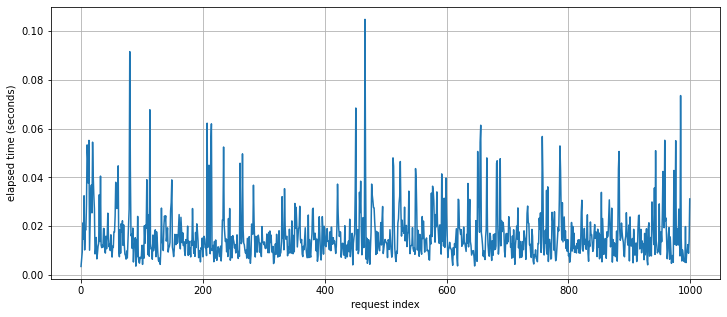

In [5]:
q = multiprocessing.Queue()

n_requests = 1000
processes = []

for i in range(n_requests):
    p = multiprocessing.Process(target=request_job, args=(q,))
    p.start()
    processes.append(p)

for p in processes:
    # call to ensure all processes finish
    p.join() 

assert q.qsize() == n_requests

elapsed_times = []
for _ in range(q.qsize()):
    elapsed_times.append(q.get())
    
q.close()
    
print('average elapsed time for {} requests is {:.6f} seconds.'.format(n_requests, np.mean(elapsed_times)))

_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(range(len(elapsed_times)), elapsed_times)
ax.grid()
ax.set_ylabel('elapsed time (seconds)')
ax.set_xlabel('request index')

average elapsed time for 1000 requests is 1.386106 seconds.


Text(0.5, 0, 'request index')

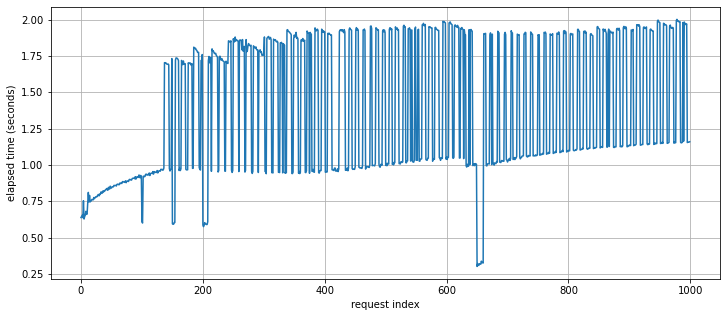

In [7]:
# same test using grequests
n_requests = 1000
rs = (grequests.post('http://localhost:5000/infer', json=contents[random.choice(range(5))]) for i in range(n_requests))
rts = grequests.map(rs)

elapsed_times = []
for rt in rts:
    if rt is None:
        print(rt)
    else:
        elapsed_times.append(rt.elapsed.total_seconds())
        
print('average elapsed time for {} requests is {:.6f} seconds.'.format(n_requests, np.mean(elapsed_times)))

_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(range(len(elapsed_times)), elapsed_times)
ax.grid()
ax.set_ylabel('elapsed time (seconds)')
ax.set_xlabel('request index')

---
---
### batched query test

In [8]:
result = requests.post('http://localhost:5000/batch', json=json.dumps(parsed_contents_batch))
print('elapsed {:.2f} seconds.'.format(result.elapsed.total_seconds()))
result = result.json()
parsed_result = [dict((('name', c['name']), ('likes', c['likes']), *list(r.items()))) for c, r in zip(parsed_contents_batch, result)]

for r in parsed_result:
    if (r['best'] == None) or (r['best'] == 'None'):
        print(r)

elapsed 0.30 seconds.


##### check against single request to see if answer match

In [9]:
check_index = 550
print(parsed_result[check_index])
result = requests.post('http://localhost:5000/infer', json=contents_batch[check_index])
print(result.json())
print('elapsed {:.2f} seconds.'.format(result.elapsed.total_seconds()))

{'name': '550', 'likes': 'Special Shish Kebab', 'best': 'Lamb Shish & Chicken Shish Kebab', 'best_sim': 483.5218637322307, 'worst': 'Irn Bru', 'worst_sim': -14.503123220313466}
{'best': 'Lamb Shish & Chicken Shish Kebab', 'best_sim': 483.52186373223077, 'worst': 'Irn Bru', 'worst_sim': -14.50312322031347}
elapsed 0.00 seconds.


##### stress test batch request

In [10]:
dumped_contents_batch = json.dumps(parsed_contents_batch)

def request_batchJob(q):
    result = requests.post('http://localhost:5000/batch', json=dumped_contents_batch)
    assert result.status_code == 200
    q.put(result.elapsed.total_seconds())

average elapsed time for 10 requests is 0.736779 seconds.


Text(0.5, 0, 'request index')

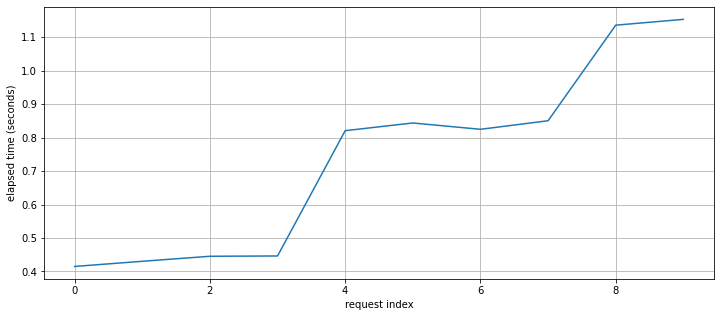

In [11]:
q = multiprocessing.Queue()

n_requests = 10
processes = []

for i in range(n_requests):
    p = multiprocessing.Process(target=request_batchJob, args=(q,))
    p.start()
    processes.append(p)

for p in processes:
    # call to ensure all processes finish
    p.join() 

assert q.qsize() == n_requests

elapsed_times = []
for _ in range(q.qsize()):
    elapsed_times.append(q.get())
    
q.close()
    
print('average elapsed time for {} requests is {:.6f} seconds.'.format(n_requests, np.mean(elapsed_times)))

_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(range(len(elapsed_times)), elapsed_times)
ax.grid()
ax.set_ylabel('elapsed time (seconds)')
ax.set_xlabel('request index')

---
---
### error handling

In [12]:
# single query
for c in contents:
    print('--------------')
    error_injection = random.randint(0, 1)
    if error_injection:
        
        error_type = random.randint(0, 3)
        print('error {} injected'.format(error_type))
        
        if error_type == 0:
            c = c.replace('vector', 'blablabla')
        elif error_type == 1:
            c = c.replace(random.choice(re.findall('(-?\d.\d*)', c)), 'NaN')
        else:
            c = ''
        print(c)
    result = requests.post('http://localhost:5000/infer', json=c)
    if error_injection:
        print(result.status_code, result.json())
    else:
        print(result.json())
    print('elapsed {:.2f} seconds.'.format(result.elapsed.total_seconds()))

--------------
{'best': 'Crispy Shredded Beef in Sweet Chilli Sauce', 'best_sim': 140.85606286283792, 'worst': 'Vimto - 0.33L', 'worst_sim': -5.752682732739032}
elapsed 0.00 seconds.
--------------
error 0 injected
{"name": "jon", "likes": "noodle soup", "blablabla": [-0.005058499984443188, -0.29045000672340393, 0.1434900015592575, 0.13824999332427979, 0.4716399908065796, 0.21820999681949615, 0.5159900188446045, -0.6810799837112427, 0.23698000609874725, 0.02863599918782711, -0.3568199872970581, 0.09322000294923782, -0.06319700181484222, -0.8709200024604797, 0.10708999633789062, 0.2696300148963928, -0.14294999837875366, 0.4329800009727478, 0.029416000470519066, 0.0632530003786087, -0.10924000293016434, -0.3901900053024292, 0.4074000120162964, -0.09043099731206894, -0.18862999975681305, 0.08396399766206741, -0.5896999835968018, -0.04342300072312355, 0.17184999585151672, -0.0937810018658638, 0.13513000309467316, -0.3946700096130371, 0.2842400074005127, -0.4658600091934204, 0.0644169971346

In [13]:
# batch query
with open('users_batch.json', 'r') as f:
    contents_batch = f.readlines()
    
error_type = 1
print('error {} selected'.format(error_type))

bad_requests = np.random.choice(range(len(contents_batch)), 2, replace=False)
for i in range(len(contents_batch)):
    if i in bad_requests:

        if error_type == 0:
            contents_batch[i] = contents_batch[i].replace('vector', 'blablabla')
        elif error_type == 1:
            contents_batch[i] = contents_batch[i].replace(random.choice(re.findall('(-?\d.\d*)', contents_batch[i])), 'NaN')
        else:
            contents_batch[i] = ''
        print(contents_batch[i])
    
parsed_contents_batch = [json.loads(l) for l in contents_batch]

result = requests.post('http://localhost:5000/batch', json=json.dumps(parsed_contents_batch))
print('elapsed {:.2f} seconds.'.format(result.elapsed.total_seconds()))

result = result.json()

if error_type == 1:
    for idx in bad_requests:
        print(result[idx])
else:
    print(result)
    #parsed_result = [dict((('name', c['name']), ('likes', c['likes']), *list(r.items()))) for c, r in zip(parsed_contents_batch, result)]

error 1 selected
{"name": "145", "likes": "Sheek Kebab Starter", "vector": [0.04857800155878067, 0.26433998346328735, 0.7025800347328186, 0.10332299768924713, 0.9430000185966492, 0.35616201162338257, 0.2010836899280548, -0.922881007194519, 0.38336002826690674, 1.882539987564087, 0.03720000386238098, -0.122421994805336, -1.368530035018921, 0.007600024342536926, 0.4430609941482544, -0.44961994886398315, -0.14447999000549316, 1.0907700061798096, 0.490339994430542, 0.42706099152565, 0.048009976744651794, -0.9178379774093628, 1.079759955406189, -0.7757800817489624, -0.08905500173568726, -0.280210018157959, -1.8430099487304688, -0.041644006967544556, 1.026319980621338, 0.025192469358444214, -0.7270560264587402, -0.33073002099990845, 0.5282520055770874, -0.5426809787750244, -0.18975800275802612, 0.5865399837493896, -0.29865002632141113, 0.39598000049591064, -0.1732499599456787, 0.6638399362564087, -0.6279889941215515, 0.2756491005420685, -0.8598019480705261, 0.38194000720977783, 0.34438398480